# Libs Loading

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

import polars as pl
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


import data_squeeze_funcs as dsf
import data_loading_funcs as dlf
import modeling_functions as mf
import feature_engineering as fef
import feat_eng_pol as fepl

pygame 2.6.1 (SDL 2.28.4, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


# 0. Data Loading

In [3]:
df_data = dlf.load_data_pl()

df_squeezed = (
    df_data
    .sort(["id", "rn"], descending=[False, True])  # Сортируем по id и rn (убывание rn)
    .unique(subset="id", keep="first")             # Оставляем только строки с уникальными id
)


df_squeezed.head(5)

id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
i32,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,bool,bool,bool,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,bool,bool
0,10,7,9,2,10,8,8,16,4,2,2,11,6,16,5,4,8,1,1,1,1,1,15,2,17,false,true,true,0,0,0,0,0,0,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,4,1,false,false
1,14,12,6,1,8,14,11,11,2,3,2,5,6,16,5,4,8,1,1,1,1,1,16,2,17,true,true,true,3,3,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,3,1,false,true
2,3,12,9,4,8,1,11,1,1,4,2,5,6,16,5,4,8,1,1,1,1,1,3,2,17,false,true,true,3,3,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,3,1,true,true
3,15,12,9,2,10,8,8,17,1,2,2,1,6,16,5,4,8,1,1,1,1,1,6,2,17,false,true,true,0,3,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,4,1,false,false
4,1,12,9,4,8,1,11,12,1,3,2,0,6,16,5,4,8,1,1,1,1,1,16,2,17,true,true,true,3,3,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,3,1,true,true


In [4]:
df_target = dlf.load_target_pl()
# df_target = df_target.slice(250000, 500000)
df_target

id,flag
i32,i8
0,0
1,0
2,0
3,0
4,0
…,…
2999995,0
2999996,0
2999997,0


# 2. Feature Gambling

In [47]:
df_feat = df_squeezed.clone()
df_feat.shape

(3000000, 60)

In [48]:
pre_loans_cols = ["pre_loans5", "pre_loans530", "pre_loans3060", "pre_loans6090", "pre_loans90"]
is_zero_loans_upto_60 = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060']
is_zero_loans_over_60 = ['is_zero_loans6090',	'is_zero_loans90']
is_zero_loans_total = [i for i in df_feat.columns if i.startswith('is_zero_loan')]
enc_paym_sum_cols = [i for i in df_feat.columns if i.startswith('enc_paym_')]



df_feat = df_feat.with_columns(
    pl.sum_horizontal(pre_loans_cols).alias("pre_loans_total").cast(pl.Int8),
    pl.sum_horizontal(is_zero_loans_upto_60).alias("is_zero_loans_upto_60").cast(pl.Int8),
    pl.sum_horizontal(is_zero_loans_over_60).alias("is_zero_loans_over_60").cast(pl.Int8),
    pl.sum_horizontal(is_zero_loans_total).alias("is_zero_loans_total").cast(pl.Int8),
    pl.sum_horizontal(enc_paym_sum_cols).alias("enc_paym_sum_total").cast(pl.Int16),
)

df_feat = fepl.credit_type_grpd(df_feat)
df_feat = fepl.cr_cost_rate_grpd(df_feat)
df_feat = fepl.pterm_grpd(df_feat)
df_feat = fepl.fterm_grpd(df_feat)
df_feat = fepl.cr_limit_grpd(df_feat)
df_feat = fepl.pre_util_grpd(df_feat)
df_feat = fepl.pre_over2limit_grpd(df_feat)
df_feat = fepl.pre_maxover2limit_grpd(df_feat)
df_feat = fepl.holder_type_grpd(df_feat)
df_feat = fepl.cr_status_grpd(df_feat)
df_feat = fepl.acc_cur_grpd(df_feat)
df_feat = fepl.since_op_grpd(df_feat)
df_feat = fepl.since_confrm_grpd(df_feat)
df_feat = fepl.till_pcl_grpd(df_feat)
df_feat = fepl.till_fcl_grpd(df_feat)
df_feat = fepl.next_pay_summ_grpd(df_feat)
df_feat = fepl.outstnd_grpd(df_feat)
df_feat = fepl.tot_overdue_grpd(df_feat)
df_feat = fepl.max_overdue_sum_grpd(df_feat)
# df_feat = fepl.paym_sum_total_grpd(df_feat)

# df_feat = df_feat.with_columns(
#     ((pl.col("pre_util_grpd")) + (pl.col("is_zero_loans_total"))).alias('util_no_overdue').cast(pl.Int8),
#     ((pl.col("pre_maxover2limit_grpd")) + (pl.col("till_pcl_grpd"))).alias('maxoverdue_till_pclose').cast(pl.Int8),
#     ((pl.col("till_fcl_grpd")) + (pl.col("tot_overdue_grpd"))).alias('delays_till_end').cast(pl.Int8),
#     ((pl.col("is_zero_loans_over_60")) + (pl.col("tot_overdue_grpd"))).alias('over60_totoverdue').cast(pl.Int8),
#     ((pl.col("is_zero_loans_upto_60")) + (pl.col("till_fcl_grpd"))).alias('upto60_fcl').cast(pl.Int8),
#     ((pl.col("outstnd_grpd")) + (pl.col("is_zero_loans_total"))).alias('outstnd_grpd + is0_tot').cast(pl.Int8),
# )


In [49]:
cols_to_drop = ["is_zero_loans_total", 'pre_util_grpd', "till_pcl_grpd", 'pre_maxover2limit_grpd', "tot_overdue_grpd", "till_fcl_grpd", 'is_zero_loans_over_60', "tot_overdue_grpd", "is_zero_loans_upto_60", "till_fcl_grpd", "enc_paym_sum_total"]

df_feat = df_feat.drop(
    pre_loans_cols 
    + is_zero_loans_total 
    + enc_paym_sum_cols 
    # + cols_to_drop
)

In [50]:
df_feat.head(3)

id,rn,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag,is_zero_loans_upto_60,is_zero_loans_over_60,is_zero_loans_total,credit_type_grpd,cr_cost_rate_grpd,pterm_grpd,fterm_grpd,cr_limit_grpd,pre_util_grpd,pre_over2limit_grpd,pre_maxover2limit_grpd,holder_type_grpd,cr_status_grpd,acc_cur_grpd,since_op_grpd,since_confrm_grpd,till_pcl_grpd,till_fcl_grpd,next_pay_summ_grpd,outstnd_grpd,tot_overdue_grpd,max_overdue_sum_grpd,paym_sum_total_grpd
i32,i16,bool,bool,bool,bool,bool,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
0,10,false,true,true,false,false,3,2,5,2,0,1,0,1,2,0,0,1,1,1,1,1,0,1,2,1,0,0,0
1,14,true,true,true,false,true,3,2,5,2,0,1,1,0,1,0,0,1,1,1,3,2,1,1,1,0,0,0,0
2,3,false,true,true,true,true,3,2,5,2,0,1,1,2,3,0,0,1,1,1,3,1,1,1,2,1,0,0,0


In [51]:
df_feat_pd = df_feat.to_pandas()
df_target_pd = df_target.to_pandas()
df_feat_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 30 columns):
 #   Column                  Dtype
---  ------                  -----
 0   id                      int32
 1   rn                      int16
 2   is_zero_util            bool 
 3   is_zero_over2limit      bool 
 4   is_zero_maxover2limit   bool 
 5   pclose_flag             bool 
 6   fclose_flag             bool 
 7   is_zero_loans_upto_60   int8 
 8   is_zero_loans_over_60   int8 
 9   is_zero_loans_total     int8 
 10  credit_type_grpd        int8 
 11  cr_cost_rate_grpd       int8 
 12  pterm_grpd              int8 
 13  fterm_grpd              int8 
 14  cr_limit_grpd           int8 
 15  pre_util_grpd           int8 
 16  pre_over2limit_grpd     int8 
 17  pre_maxover2limit_grpd  int8 
 18  holder_type_grpd        int8 
 19  cr_status_grpd          int8 
 20  acc_cur_grpd            int8 
 21  since_op_grpd           int8 
 22  since_confrm_grpd       int8 
 23  till_pc

In [52]:
X = df_feat_pd
y = df_target_pd.flag

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, stratify=y, random_state=137
)

In [53]:
best_params_df = pd.read_csv('data/best_params_3M.csv')
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'iterations': 1950,
 'max_depth': 5,
 'learning_rate': 0.0580725932505487,
 'l2_leaf_reg': 7.117155502550276,
 'border_count': 235,
 'random_strength': 0.114913649377385,
 'bagging_temperature': 0.3154890352960704}

In [54]:
message = 'paym_sum_total_grpd added'

In [55]:
cbc_best = CatBoostClassifier(
    **best_params,
    random_seed=137,
    cat_features=[i for i in X.columns if X[i].dtype == "category"],
    eval_metric='AUC',
    task_type='GPU',
    logging_level='Silent',
    # iterations=1400,
    # max_depth=5,
    # learning_rate=.13,
    # l2_leaf_reg=.002,
    # border_count=87,
    # random_strength=.04,
    # bagging_temperature=0.06
)

cbc_best.fit(X_train, y_train)
y_pred = cbc_best.predict_proba(X_test)[:, 1]

score = roc_auc_score(y_test, y_pred)
with open("results.txt", "a") as f:
    string = f"AUC with {message:40}: {score:.2%}"
    print(string)
    f.write(f"\n{type(cbc_best).__name__}\n{string}\n")
# fef.playsound()

Default metric period is 5 because AUC is/are not implemented for GPU


AUC with paym_sum_total_grpd added               : 70.58%


Default metric period is 5 because AUC is/are not implemented for GPU


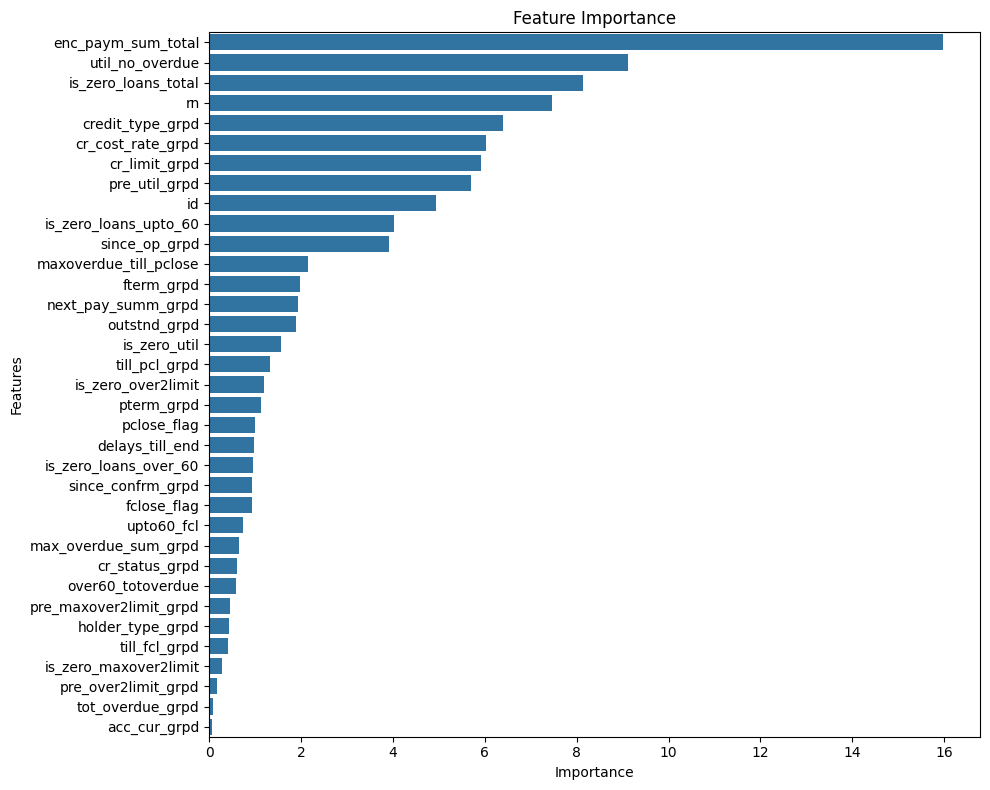

In [ ]:
# Создание и обучение модели
catboost_model = CatBoostClassifier(
    **best_params,
    random_seed=137,           # Для воспроизводимости (random_state)
    eval_metric='AUC',         # Метрика для оценки
    task_type="GPU",           # Использование GPU
    verbose=0,                 # Отключение лишнего вывода
    cat_features=[]            # Укажи, если есть категориальные признаки
)

# Обучение модели
catboost_model.fit(X, y)

# Получение важности признаков
feature_importance = catboost_model.get_feature_importance(prettified=True)

# Сортировка важности признаков
best_features_sorted = feature_importance.sort_values(by="Importances", ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(
    x=best_features_sorted["Importances"], 
    y=best_features_sorted["Feature Id"]
)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

selected_features = best_features_sorted[best_features_sorted["Importances"] > 1]
sel_feats_list = selected_features['Feature Id'].to_list()
df_cut = df_feat_pd[sel_feats_list]
df_cut['flag'] = df_target_pd['flag']

# Размер итогового DataFrame
print(df_cut.shape)
